In [70]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
pitchers_df = pd.read_csv('Data/pitchers_complete.csv')

In [36]:
pitchers_df.shape

(8987, 25)

In [37]:
pitchers_train_model = pitchers_df[pitchers_df['eligible_for_hall']=='eligible']
pitchers_train_model.head()

,playerID,nameFirst,nameLast,Seasons,Wins,Loses,Games,Games_Started,Complete_Games,Shut_Outs,...,Batters_Faced,weight,height,bats,throws,finalGame,yearid,inducted,years_since_final_game,eligible_for_hall
1,aasedo01,Don,Aase,13,66,60,448,91,22,5,...,4730.0,190.0,75.0,R,R,1990-10-03,0.0,N,29.128767,eligible
5,abbotgl01,Glenn,Abbott,12,62,83,248,206,37,5,...,5508.0,200.0,78.0,R,R,1984-08-08,0.0,N,35.284932,eligible
6,abbotji01,Jim,Abbott,11,87,108,263,254,31,6,...,7211.0,200.0,75.0,L,L,1999-07-21,0.0,N,20.326027,eligible
8,abbotpa01,Paul,Abbott,12,43,37,162,112,1,0,...,3187.0,185.0,75.0,R,R,2004-08-07,0.0,N,15.273973,eligible
12,abernte02,Ted,Abernathy,17,63,69,681,34,7,2,...,4963.0,215.0,76.0,R,R,1972-09-30,0.0,N,47.147945,eligible


In [76]:
scale_pos_weight = (pitchers_train_model.inducted.value_counts()[0])/pitchers_train_model.inducted.value_counts()[1]
print(scale_pos_weight)

18.463768115942027


In [38]:
# Getting data ready for machine learning
data = pitchers_train_model.drop(['inducted', 'playerID', 'nameFirst', 'nameLast', 'finalGame','bats', 
                                  'throws','weight', 'height','yearid','years_since_final_game', 
                                  'eligible_for_hall'], axis=1)
data.fillna(0, inplace=True)
data['Batters_Faced']=pd.to_numeric(data['Batters_Faced'])
target = pitchers_train_model['inducted']
target.fillna('N', inplace=True)
feature_names = data.columns

/Users/chris.marchetti/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

/Users/chris.marchetti/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/chris.marchetti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/Users/chris.marchetti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [40]:
len(X_test)

336

Machine Learning Model - Balanced Random Forest Classifier

In [41]:
clf = BalancedRandomForestClassifier(random_state=0)
clf = clf.fit(X_train_scaled, y_train)
clf.score(X_test_scaled, y_test)

0.9196428571428571

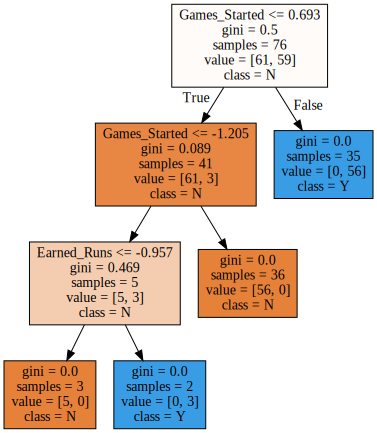

In [42]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf.estimators_[10], 
                                feature_names = feature_names, 
                                class_names=['N', 'Y'] , #y_train.columns,
                                filled = True
#,
#                                 proportion = True,
#                                 leaves_parallel=True
                               )
graph = graphviz.Source(dot_data)
graph

[[300  27]
 [  0   9]]
score for yesses, 1.0
The score is the fraction of yesses, you predicted 0.8260869565217391
              precision    recall  f1-score   support

           N       1.00      0.92      0.96       327
           Y       0.25      1.00      0.40         9

   micro avg       0.92      0.92      0.92       336
   macro avg       0.62      0.96      0.68       336
weighted avg       0.98      0.92      0.94       336



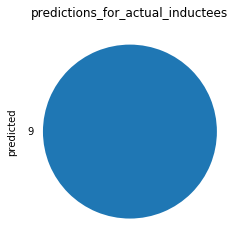

In [43]:
y_predicted = clf.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predicted))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_predicted,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
# pd.Series(y_test).value_counts()#[:20]
actual_inductees = predictions_df.loc[predictions_df.actual=='Y']
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
predictions_for_actual_inductees .plot(kind='pie', title='predictions_for_actual_inductees',  labels=predictions_for_actual_inductees.values)

print(f"score for yesses, {clf.score(actual_inductees.drop(['predicted', 'actual'],axis=1),actual_inductees .actual)}")
print('The score is the fraction of yesses, you predicted',  19/(4+19))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted)) #actual_inductees.values.reshape(-1), predictions_for_actual_inductees)
# print(y_predicted.shape)
# print(y_test.shape)

In [44]:
print(clf.feature_importances_)

[0.01332945 0.22841545 0.05384302 0.04029793 0.10055195 0.06668829
 0.08355742 0.0273054  0.14682526 0.03505868 0.03239529 0.06285057
 0.10888128]


<BarContainer object of 13 artists>

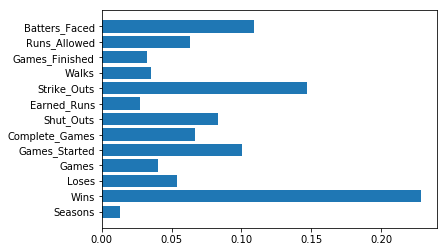

In [45]:
plt.barh(feature_names,clf.feature_importances_)


Machine Learning Model - XGboost

In [46]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [47]:
# fit model to training data
model = XGBClassifier(scale_pos_weight=1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.92%


[[324   3]
 [  4   5]]
Y    5
N    4
Name: predicted, dtype: int64
The score is the fraction of yesses, you predicted 0.4782608695652174
              precision    recall  f1-score   support

           N       0.99      0.99      0.99       327
           Y       0.62      0.56      0.59         9

   micro avg       0.98      0.98      0.98       336
   macro avg       0.81      0.77      0.79       336
weighted avg       0.98      0.98      0.98       336



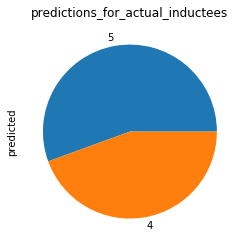

In [48]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_pred,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
# pd.Series(y_test).value_counts()#[:20]
actual_inductees = predictions_df.loc[predictions_df.actual=='Y']
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
print(predictions_for_actual_inductees)
predictions_for_actual_inductees.plot(kind='pie', title='predictions_for_actual_inductees',  labels=predictions_for_actual_inductees.values)

# print(f"score for yesses, {model.score(actual_inductees.drop(['predicted', 'actual'],axis=1),actual_inductees .actual)}")
print('The score is the fraction of yesses, you predicted',  11/(12+11))
print(classification_report(y_test, y_pred))

<BarContainer object of 13 artists>

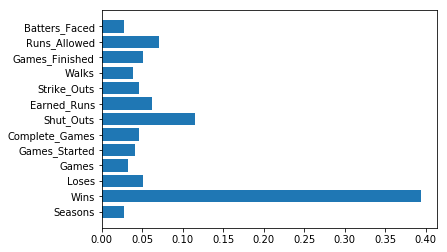

In [49]:
plt.barh(feature_names,model.feature_importances_)

In [50]:
# Run all data through the model to determine who should be in the hall of fame.
data_total = pitchers_df.drop(['inducted', 'playerID', 'nameFirst', 'nameLast', 'finalGame','bats', 
                                  'throws','weight', 'height','yearid','years_since_final_game', 
                                  'eligible_for_hall'], axis=1)
data_total.fillna(0, inplace=True)
data_total['Batters_Faced'].fillna(0, inplace=True)
data_total['Batters_Faced']=pd.to_numeric(data['Batters_Faced'])
# data_total.head()
data_total=data_total.fillna(0)
data_total.head()

,Seasons,Wins,Loses,Games,Games_Started,Complete_Games,Shut_Outs,Earned_Runs,Strike_Outs,Walks,Games_Finished,Runs_Allowed,Batters_Faced
0,9,16,18,331,0,0,0,160,340,183,141,169,0.0
1,13,66,60,448,91,22,5,468,641,457,235,503,4730.0
2,9,8,27,363,6,0,0,129,271,113,96,137,0.0
3,6,22,40,79,65,52,0,285,161,192,14,442,0.0
4,1,0,2,3,1,1,0,9,1,8,2,14,0.0


In [51]:
data_total_scaler = StandardScaler().fit(data_total)
data_total_scaled = data_total_scaler.transform(data_total)
data_total_predicted = model.predict(data_total_scaled)


/Users/chris.marchetti/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/chris.marchetti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [52]:
pitchers_predict_df = pd.concat([pitchers_df, pd.Series(data_total_predicted)], axis=1)
pitchers_predict_df = pitchers_predict_df.rename(columns={0:'model_predict'})
pitchers_predict_df['Comparison']=pitchers_predict_df['inducted']==pitchers_predict_df['model_predict']
pitchers_predict_df.head()

,playerID,nameFirst,nameLast,Seasons,Wins,Loses,Games,Games_Started,Complete_Games,Shut_Outs,...,height,bats,throws,finalGame,yearid,inducted,years_since_final_game,eligible_for_hall,model_predict,Comparison
0,aardsda01,David,Aardsma,9,16,18,331,0,0,0,...,75.0,R,R,2015-08-23,0.0,N,4.224658,not_eligible,N,True
1,aasedo01,Don,Aase,13,66,60,448,91,22,5,...,75.0,R,R,1990-10-03,0.0,N,29.128767,eligible,N,True
2,abadfe01,Fernando,Abad,9,8,27,363,6,0,0,...,73.0,L,L,2017-10-01,0.0,N,2.115068,not_eligible,N,True
3,abbeybe01,Bert,Abbey,6,22,40,79,65,52,0,...,71.0,R,R,1896-09-23,0.0,N,123.216438,not_eligible,N,True
4,abbotda01,Dan,Abbott,1,0,2,3,1,1,0,...,71.0,R,R,1890-05-23,0.0,N,129.558904,not_eligible,N,True


In [53]:
pitchers_predict_df['yearid'] = pitchers_predict_df['yearid'].astype('int').replace(0, 'N/A')


In [54]:
# Write final pitchers dataframe to csv
# pitchers_predict_df.to_csv('Data/pitchers_predicted.csv', index=False)

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [57]:
y_pred = knn.predict(X_test_scaled)

In [58]:
from imblearn.over_sampling import ADASYN 

In [59]:
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(X_train_scaled,y_train)

In [60]:
clf_ada = BalancedRandomForestClassifier(random_state=0)
clf_ada = clf.fit(X_ada, y_ada)
clf.score(X_test_scaled, y_test)

0.9583333333333334

[[314  13]
 [  1   8]]
score for yesses, 0.8888888888888888
The score is the fraction of yesses, you predicted 0.8260869565217391
              precision    recall  f1-score   support

           N       1.00      0.96      0.98       327
           Y       0.38      0.89      0.53         9

   micro avg       0.96      0.96      0.96       336
   macro avg       0.69      0.92      0.76       336
weighted avg       0.98      0.96      0.97       336



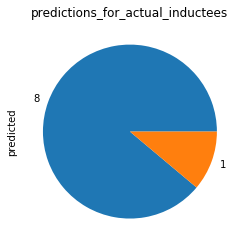

In [61]:
y_predicted_ada = clf_ada.predict(X_test_scaled)
# from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predicted_ada))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_predicted_ada,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
# pd.Series(y_test).value_counts()#[:20]
actual_inductees = predictions_df.loc[predictions_df.actual=='Y']
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
predictions_for_actual_inductees.plot(kind='pie', title='predictions_for_actual_inductees', labels=predictions_for_actual_inductees.values)

print(f"score for yesses, {clf.score(actual_inductees.drop(['predicted', 'actual'],axis=1),actual_inductees .actual)}")
print('The score is the fraction of yesses, you predicted',  19/(4+19))

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted_ada)) #actual_inductees.values.reshape(-1), predictions_for_actual_inductees)
# print(y_predicted.shape)
# print(y_test.shape)

In [62]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled,y_train)
model_smote_tomek = XGBClassifier(scale_pos_weight=1)
model_smote_tomek.fit(X_resampled, y_resampled)
y_pred_smote_tomek = model_smote_tomek.predict(X_train_scaled)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(len(X_resampled), len(y_resampled))

1890 1890


In [63]:
model.score(X_test_scaled, y_test)

0.9791666666666666

In [65]:
y_predicted_ada = clf_ada.predict(X_test_scaled)
# from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_pred_smote_tomek,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
# pd.Series(y_test).value_counts()#[:20]
actual_inductees = predictions_df.loc[predictions_df.actual=='Y']
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
predictions_for_actual_inductees.plot(kind='pie', title='predictions_for_actual_inductees', labels=predictions_for_actual_inductees.values)

print(f"score for yesses, {clf.score(actual_inductees.drop(['predicted', 'actual'],axis=1),actual_inductees .actual)}")
print('The score is the fraction of yesses, you predicted',  19/(4+19))

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted_smote_tomek)) #actual_inductees.values.reshape(-1), predictions_for_actual_inductees)
# print(y_predicted.shape)
# print(y_test.shape)

[[324   3]
 [  5   4]]


ValueError: array length 1007 does not match index length 336